#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [3]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean, z_var = inputs

        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]

        z=z_mean + tf.exp(z_var/2)*tf.keras.backend.random_normal(shape=(batch, dim))

      
        return z




##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)

Discussion:

In order to choose the number of layers and the layers sizes i've considered that i can make the variational autoencoder's architecture very powerful by increasing the number of layers and nodes per layer. I think that increasing these hyperparameters will let us to learn more complex codings. On the other hand it should not be too powerful otherwise we won't learn any meaningful representation. In the end i've choosen to use 3 dense layers as written in the exercise with 512, 256 and 128 as sizes in order to let the model learn better and encode in a more compact form. I have tried with more/less than 3 dense layers but it doesn't seem to affect to much the performance. I have also tried with smaller and bigger sizes but the plot at the end seems fine with this configuration because i think that i have obtained a good trade off between complexity and meaningful representation. From a practical aspect of view higher sizes lead to good representation but too many params and increased time of computation, smaller sizes have less params but less accurate representation.
I decided to use relu activation function as it should be a standard in this case according to the documentation. I've also tried to change it but it seems that relu is the best. I have seen that for example using sigmoid or tanh as activation function produced a worsening on the loss(29) and the plot isn't good probably due to vanishing gradient problem. 

In [4]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))

x = tf.keras.layers.Dense(512, activation="relu")(encoder_inputs)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)


z_mean =  tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var =  tf.keras.layers.Dense(latent_dim)(x) #[TO COMPLETE] Hint: size would be = latent_dim

z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          131328      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 128)          32896       dense_1[0][0]                    
____________________________________________________________________________________________

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

I have chosen to use 2 layers in order to let the decoder architecture be specular to the encoder one. The layer sizes just occur in the reverse order of the encoder. I dediced to use the same activation function(relu) since it was the best solution and for the last layer sigmoid since to generate grayscale images we need output in [0,1].

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = tf.keras.layers.Dense(128, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(256, activation="relu")(x)

decoder_outputs = tf.keras.layers.Dense(784, activation="sigmoid")(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_7 (Dense)              (None, 784)               201488    
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

    
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data,reconstruction)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5*((1+z_var)-tf.square(z_mean)-tf.exp(z_var)), axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [7]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 6s 15ms/step - loss: 35.1875 - reconstruction_loss: 33.9736 - kl_loss: 1.2139
Epoch 2/30
391/391 [==============================] - 6s 14ms/step - loss: 31.4686 - reconstruction_loss: 29.9718 - kl_loss: 1.4968
Epoch 3/30
391/391 [==============================] - 6s 15ms/step - loss: 30.4665 - reconstruction_loss: 28.3254 - kl_loss: 2.1412
Epoch 4/30
391/391 [==============================] - 6s 14ms/step - loss: 29.9578 - reconstruction_loss: 27.5452 - kl_loss: 2.4126
Epoch 5/30
391/391 [==============================] - 6s 14ms/step - loss: 29.6418 - reconstruction_loss: 27.0472 - kl_loss: 2.5946
Epoch 6/30
391/391 [==============================] - 5s 14ms/step - loss: 29.3956 - reconstruction_loss: 26.6248 - kl_loss: 2.7708
Epoch 7/30
391/391 [==============================] - 5s 14ms/step - loss: 29.1618 - reconstruction_loss: 26.2430 - kl_loss: 2.9188
Epoch 8/30
391/391 [==============================] - 6s 14ms/step - loss: 2

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

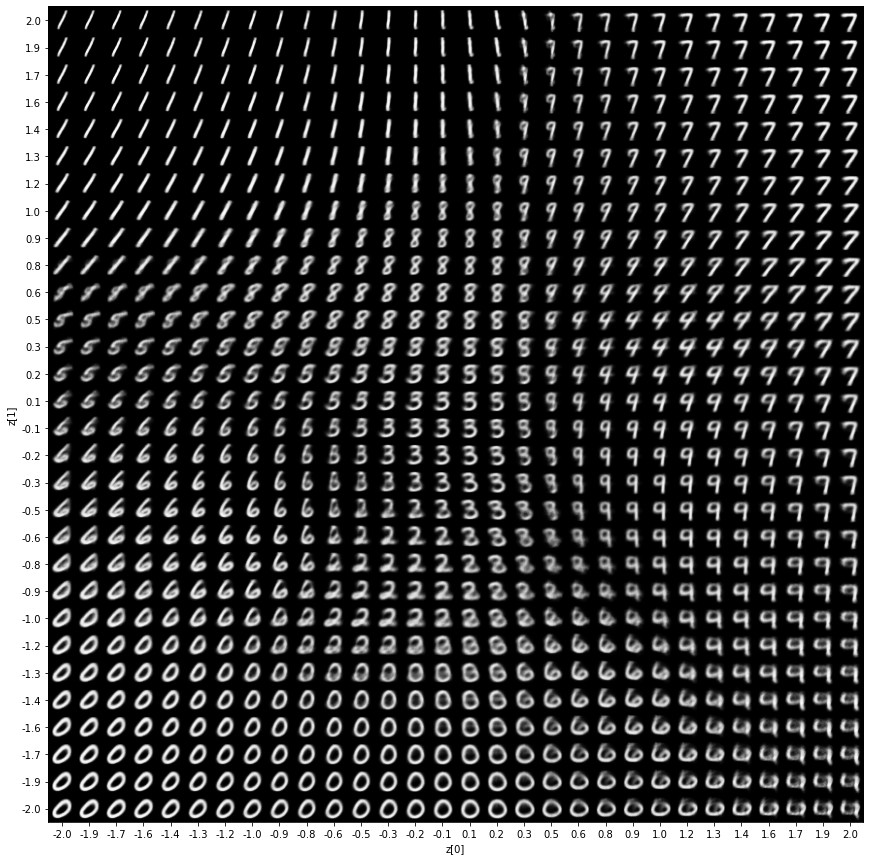

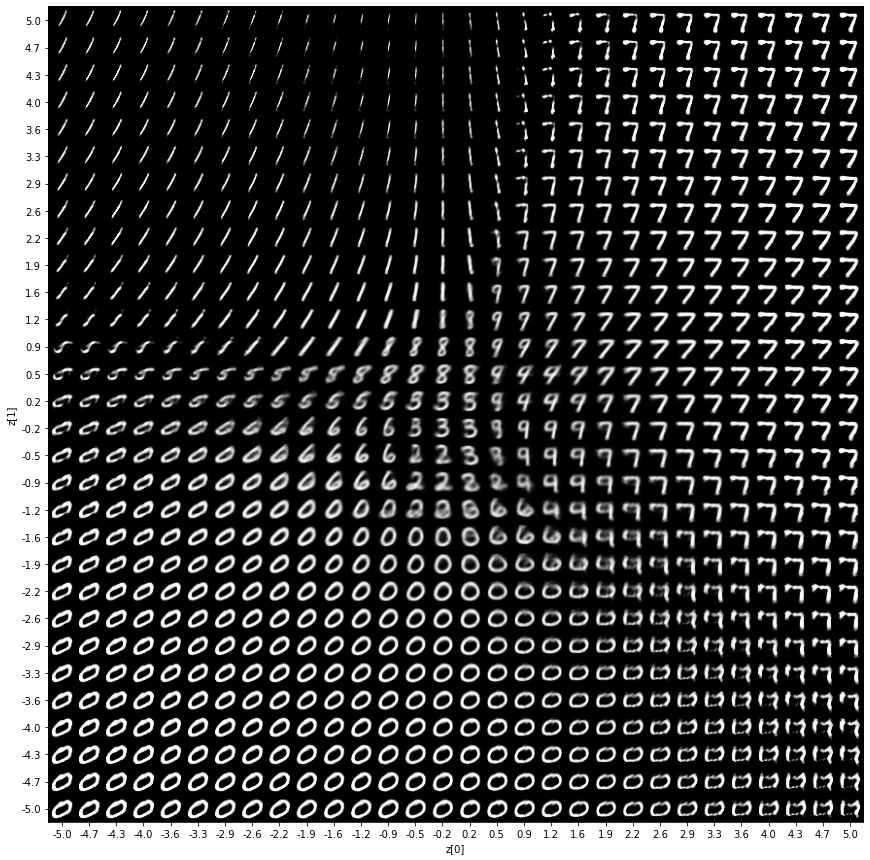

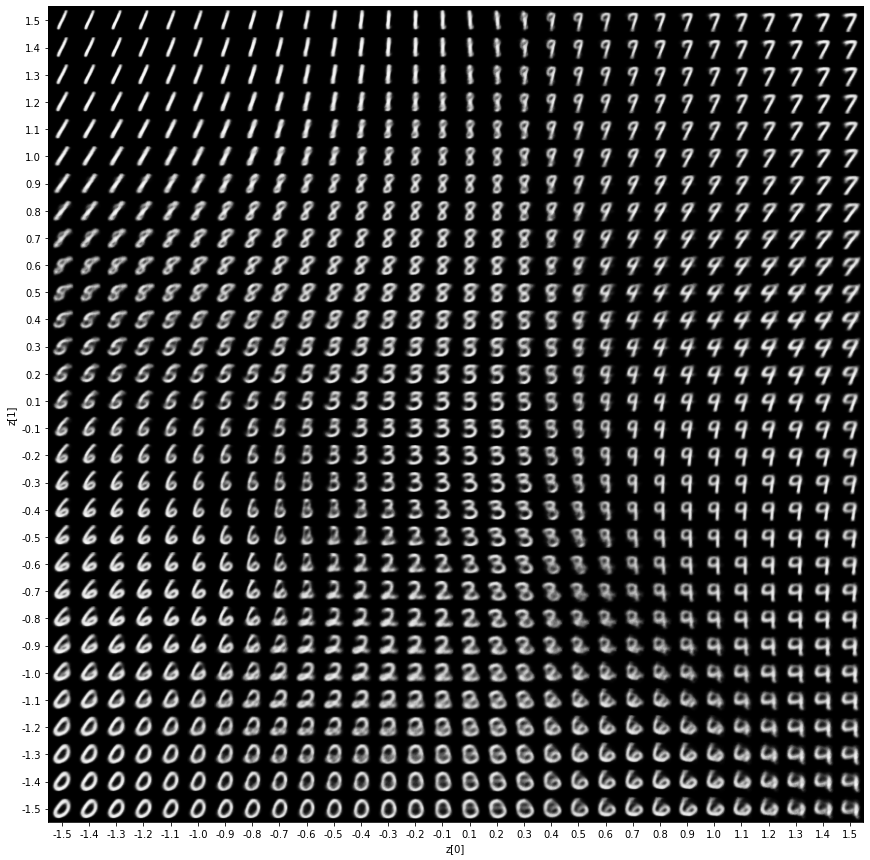

In [8]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore with different "scale"


plot_latent(encoder, decoder, 5.0, 30) 


plot_latent(encoder, decoder, 1.5, 30) 


Let's finally check how the various digits have been rapresented in the latent space by the VAE.

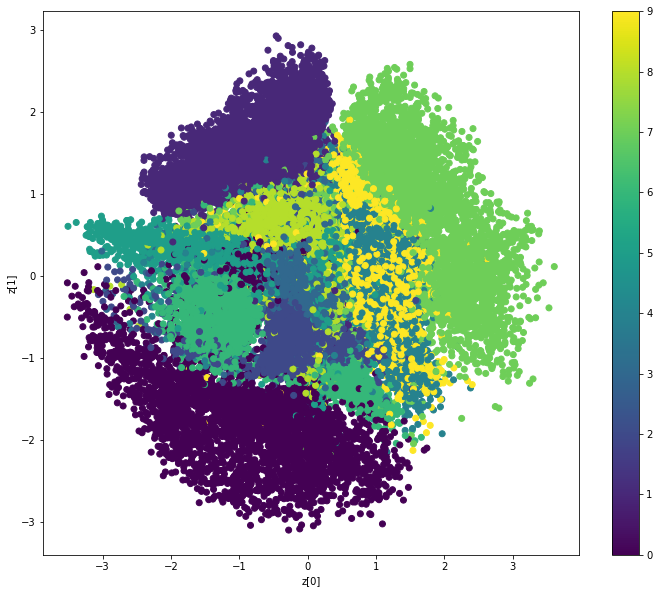

In [9]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

The above results confirm that the model is able to reconstruct the numbers with decent efficiency. One thing that i noticed here is that the output images are a little blurry but this should be common with variational autoencoders since they are not actually designed to reconstruct the images, the real purpose is learning the distribution.The variational autoencoders learn the underlying distribution of the latent features so it basically means that the latent encodings of the samples belonging to the same class should not be very far from each other in the latent space. The above plot shows this. Embeddings of the same numbers are closer in the latent space. Unfortunately there are some points that are clearly where they shouldn't be or some points that are a bit mixed so the latent space is a bit irregular with some boundaries that are not clearly distinguishable between the clusters of the different classes but this is the best i could achieve.

After several tries with different hyper-parameters i found substantial performance differences due to the number of layers, layers sizes and activation functions in encoder/decoder. As i have already written in the explanation of the choice of parameters in the encoder exercise when we have to choose the hyperparameters we have to pay attention to the complexity and the ouput results since they have to be meaningful. Changing the number of layers doens't seem to change too much the plot so i kept the 3 dense layer in order to mantain the model simpler. The latent presentation and generation quality are supposed to be improved when VAE goes deeper but i didn't want to make a too much complex model and i also didn't notice really good improvements.
Regarding the size of layer it seems that increasing them we have better representation but too much params. On the other side decreasing the size of layer we obtain a simpler model with a less accurate representation. Regarding the activation standard the setup i have chosen is the best (relu + sigmoid in output) due to the nature of the data. Moreover i have noticed that changing the activation function does change quite a bit the spatial placements of the digits in the plot. 
